# **Rent of Indian Houses Project**

## **Import Packages and Load Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
df= pd.read_csv("/kaggle/input/indian-houses-for-rent/Indian_House_Rent_Dataset.csv")
print("Shape of the data: ",df.shape)

Shape of the data:  (4746, 12)


In [3]:
pd.set_option('display.max_columns', None)
data= df.copy()
data.head()

,Posted On,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rent
0,NaN,2.0,1100.0,NaN,Super Area,Bandel,India-! Kolkata,Unfurnished,Bach^elors/Fam.ily,2.0,Contact Owner,10000
1,2022-05-13,2.0,800.0,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",India-! Kolkata,Semi-Furnished,Bachelors\/Family*,NaN,NaN,20000
2,2022-05-16,2.0,1000.0,1 out of 3,Super Area,Salt Lake City Sector 2,India-- Kolkata,Semi-Furnished,NaN,1.0,Contact Owner,17000
3,2022-07-04,2.0,800.0,1 out of 2,Super Area,NaN,NaN,Unfurnished,Bachel]ors/F@amily,1.0,NaN,10000
4,2022-05-09,2.0 room,850.0,1 out of 2,Carpet Area,South Dum Dum,India-^ Kolkata,Unfurnished,Bache[lors&,1.0,Contact Owner,7500


## **Exploring Data**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4084 non-null   object
 1   BHK                3963 non-null   object
 2   Size               3826 non-null   object
 3   Floor              3960 non-null   object
 4   Area Type          3804 non-null   object
 5   Area Locality      4146 non-null   object
 6   City               4091 non-null   object
 7   Furnishing Status  4042 non-null   object
 8   Tenant Preferred   4094 non-null   object
 9   Bathroom           4205 non-null   object
 10  Point of Contact   4137 non-null   object
 11  Rent               4746 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 445.1+ KB


In [5]:
data.describe()

,Rent
count,4.746000e+03
mean,3.499345e+04
std,7.810641e+04
min,1.200000e+03
25%,1.000000e+04
50%,1.600000e+04
75%,3.300000e+04
max,3.500000e+06


In [6]:
data.describe(include='O')

,Posted On,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
count,4084,3963,3826,3960,3804,4146,4091,4042,4094,4205,4137
unique,81,12,588,433,5,2017,360,3,4051,13,2
top,2022-07-06,2.0,1000.0,1 out of 2,Super Area,Bandra West,"India-, Mumbai",Semi-Furnished,Bach=elors/Fa/mily,2.0,Contact Owner
freq,265,1886,190,324,1971,34,24,1908,2,1995,2815


In [7]:
data.isnull().sum()

Posted On            662
BHK                  783
Size                 920
Floor                786
Area Type            942
Area Locality        600
City                 655
Furnishing Status    704
Tenant Preferred     652
Bathroom             541
Point of Contact     609
Rent                   0
dtype: int64

In [8]:
data.columns

Index(['Posted On', 'BHK', 'Size', 'Floor', 'Area Type', 'Area Locality',
       'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom',
       'Point of Contact', 'Rent'],
      dtype='object')

## **Data Cleaning & Feature Engineering**

In [9]:
data['Posted On'].unique()

array([nan, '2022-05-13', '2022-05-16', '2022-07-04', '2022-05-09',
       '2022-04-29', '2022-06-21', '2022-06-07', '2022-05-23',
       '2022-05-05', '2022-05-17', '2022-06-20', '2022-06-09',
       '2022-06-14', '2022-05-28', '2022-05-22', '2022-06-25',
       '2022-06-22', '2022-05-21', '2022-06-26', '2022-06-16',
       '2022-06-29', '2022-05-10', '2022-05-12', '2022-05-31',
       '2022-06-10', '2022-06-06', '2022-05-20', '2022-07-02',
       '2022-07-03', '2022-04-23', '2022-05-14', '2022-05-27',
       '2022-06-19', '2022-07-06', '2022-06-04', '2022-06-24',
       '2022-05-18', '2022-05-30', '2022-06-18', '2022-06-08',
       '2022-05-03', '2022-05-07', '2022-06-27', '2022-04-28',
       '2022-06-28', '2022-06-23', '2022-06-13', '2022-05-15',
       '2022-05-04', '2022-04-25', '2022-05-06', '2022-06-30',
       '2022-07-01', '2022-06-17', '2022-05-26', '2022-05-11',
       '2022-06-12', '2022-06-05', '2022-06-11', '2022-05-25',
       '2022-06-01', '2022-04-30', '2022-05-24', '

## **Note**:
##### The 'Year' is constant (2022) for all entries, so it will not add predictive value to the model. 
##### Instead, we will perform feature engineering on the 'Month' to capture more meaningful information.

In [10]:
data['Posted On']= pd.to_datetime(data['Posted On'], errors='coerce')
data['Posted_Month']= data['Posted On'].dt.month

In [11]:
data['Posted_Month'].unique()

array([nan,  5.,  7.,  4.,  6.])

In [12]:
data.drop('Posted On', axis=1, inplace=True)

In [13]:
data.head()

,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rent,Posted_Month
0,2.0,1100.0,NaN,Super Area,Bandel,India-! Kolkata,Unfurnished,Bach^elors/Fam.ily,2.0,Contact Owner,10000,NaN
1,2.0,800.0,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",India-! Kolkata,Semi-Furnished,Bachelors\/Family*,NaN,NaN,20000,5.0
2,2.0,1000.0,1 out of 3,Super Area,Salt Lake City Sector 2,India-- Kolkata,Semi-Furnished,NaN,1.0,Contact Owner,17000,5.0
3,2.0,800.0,1 out of 2,Super Area,NaN,NaN,Unfurnished,Bachel]ors/F@amily,1.0,NaN,10000,7.0
4,2.0 room,850.0,1 out of 2,Carpet Area,South Dum Dum,India-^ Kolkata,Unfurnished,Bache[lors&,1.0,Contact Owner,7500,5.0


In [14]:
data['BHK'].value_counts()

BHK
2.0         1886
1.0          922
3.0          893
4.0          158
2.0 room      35
1.0 room      25
3.0 room      18
5.0           15
6.0            4
4.0 room       4
5.0 room       2
6.0 room       1
Name: count, dtype: int64

In [15]:
# we will extract number of bedrooms from the string using regular expressions

data['BHK']= data['BHK'].astype(str).str.extract('(\d+)').astype(float)

In [16]:
data['BHK'].value_counts()

BHK
2.0    1921
1.0     947
3.0     911
4.0     162
5.0      17
6.0       5
Name: count, dtype: int64

In [17]:
data['Size'].value_counts()

Size
1000.0               190
600.0                181
800.0                180
500.0                158
1200.0               156
                    ... 
1771.0                 1
3150.0                 1
1045.0                 1
1400.0Square Feet      1
855.0                  1
Name: count, Length: 588, dtype: int64

In [18]:
data['Size']= data['Size'].astype(str).str.extract('(\d+)').astype(float)

In [19]:
data['Size'].unique()

array([1100.,  800., 1000.,  850.,  600.,  700.,  250.,   nan, 1200.,
        400.,  375.,  900., 1286., 2000.,  650.,  300., 1600.,  355.,
        350.,  550.,  500.,  630.,  270., 1500., 1068.,  150.,  450.,
        720.,  680.,  950., 1800.,  480.,  435., 1300., 1450.,  750.,
        220.,   20.,  200.,  840.,  740.,  490.,  280.,  120., 1220.,
        670.,  240., 2200.,  685.,   44.,  392.,  710., 1400.,  160.,
       1250.,  839.,  230.,  620., 1350.,  723.,  320., 2160., 1700.,
        130.,  505., 4000., 1190., 1012.,  812.,  420., 1750.,  830.,
       1050.,  960.,  756.,  288.,  986.,  322.,  957., 1430., 1320.,
        475.,  570.,  460.,  530.,  558.,  175.,  721., 2210.,  675.,
       1880.,  640.,  518.,  777., 2308.,  890.,  888.,  275.,  424.,
        610.,  722., 1150.,  470.,  410.,  932.,  560., 3000.,  751.,
        696., 2500.,  715., 1337.,  737.,  760.,  365., 1330., 2600.,
       1783.,  565., 1080.,  825., 1545.,  780.,  695., 1095.,  790.,
        661.,  330.,

In [20]:
data['Floor']

0                NaN
1         1 out of 3
2         1 out of 3
3         1 out of 2
4         1 out of 2
            ...     
4741      3 out of 5
4742      1 out of 4
4743             NaN
4744    23 out of 34
4745      4 out of 5
Name: Floor, Length: 4746, dtype: object

In [21]:
data['Floor'].unique()

array([nan, '1 out of 3', '1 out of 2', 'Ground out of 1',
       'Ground out of 4', '1 out of 4', '1 out of 1', 'Ground out of 2',
       'Ground out of 3', '2 out of 3', '4 out of 5', '2 out of 2',
       '2 out of 5', '3 out of 3', '5 out of 5', '4 out of 4',
       '7 out of 8', '2 out of 4', '3 out of 4', '1 out of 5',
       'Ground out of 6', 'Upper Basement out of 4', 'Ground out of 5',
       '3 out of 5', '11 out of 19', '5 out of 10', '11 out of 14',
       'Lower Basement out of 2', '2 out of 7', '4 out of 10',
       '7 out of 10', '2 out of 13', '6 out of 7', '4 out of 7',
       '14 out of 14', '43 out of 78', '2 out of 8', '13 out of 18',
       '18 out of 24', '3 out of 7', '17 out of 31', '11 out of 21',
       '14 out of 23', '19 out of 24', '3 out of 21', '8 out of 8',
       '6 out of 12', '4 out of 58', '60 out of 66', '34 out of 48',
       '5 out of 8', '14 out of 40', '5 out of 7', '26 out of 44',
       '1 out of 8', '25 out of 42', '25 out of 41', '53 out of 

In [22]:
data['Floor']= data['Floor'].replace({
    r'^Ground': '0',
    r'^Upper Basement': '-1',
    r'^Lower Basement': '-2'
}, regex=True)

In [23]:
data['Floor'].unique()

array([nan, '1 out of 3', '1 out of 2', '0 out of 1', '0 out of 4',
       '1 out of 4', '1 out of 1', '0 out of 2', '0 out of 3',
       '2 out of 3', '4 out of 5', '2 out of 2', '2 out of 5',
       '3 out of 3', '5 out of 5', '4 out of 4', '7 out of 8',
       '2 out of 4', '3 out of 4', '1 out of 5', '0 out of 6',
       '-1 out of 4', '0 out of 5', '3 out of 5', '11 out of 19',
       '5 out of 10', '11 out of 14', '-2 out of 2', '2 out of 7',
       '4 out of 10', '7 out of 10', '2 out of 13', '6 out of 7',
       '4 out of 7', '14 out of 14', '43 out of 78', '2 out of 8',
       '13 out of 18', '18 out of 24', '3 out of 7', '17 out of 31',
       '11 out of 21', '14 out of 23', '19 out of 24', '3 out of 21',
       '8 out of 8', '6 out of 12', '4 out of 58', '60 out of 66',
       '34 out of 48', '5 out of 8', '14 out of 40', '5 out of 7',
       '26 out of 44', '1 out of 8', '25 out of 42', '25 out of 41',
       '53 out of 78', '0 out of 7', '14 out of 20', '16 out of 23',
   

In [24]:
data['Current_Floor']= data['Floor'].astype(str).str.extract(r'^(-?\d+)')[0].astype(float)
data['Total_Floors']= data['Floor'].astype(str).str.extract(r'out of (\d+)')[0].astype(float)

data['Total_Floors']= np.where(data['Total_Floors'].isna() & data['Current_Floor'].notna(), data['Current_Floor'], data['Total_Floors'])

In [25]:
data['Current_Floor'].unique()

array([nan,  1.,  0.,  2.,  4.,  3.,  5.,  7., -1., 11., -2.,  6., 14.,
       43., 13., 18., 17., 19.,  8., 60., 34., 26., 25., 53., 16., 39.,
       10., 12., 32., 47., 28.,  9., 20., 15., 65., 40., 37., 21., 30.,
       35., 22., 44., 41., 46., 27., 48., 50., 24., 29., 23., 36., 76.,
       45.])

In [26]:
data['Total_Floors'].unique()

array([nan,  3.,  2.,  1.,  4.,  5.,  8.,  6., 19., 10., 14.,  7., 13.,
       78., 18., 24., 31., 21., 23., 12., 58., 66., 48., 40., 44., 42.,
       41., 20., 60., 32., 89., 30., 15., 16., 11., 28., 22., 17., 45.,
       35.,  9., 75., 38., 51., 43., 25., 27., 76., 36., 37., 55., 68.,
       29., 26., 50., 62., 52., 54., 33., 46., 85., 71., 81., 34.])

In [27]:
mask= data['Current_Floor']> data['Total_Floors']

In [28]:
mask.unique()

array([False])

# **Note**:
##### Data validation confirmed that Current_Floor values are always less than or equal to the corresponding Total_Floors. Therefore, no swapping operation is required

In [29]:
data.drop('Floor', axis=1, inplace=True)

In [30]:
data.head()

,BHK,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors
0,2.0,1100.0,Super Area,Bandel,India-! Kolkata,Unfurnished,Bach^elors/Fam.ily,2.0,Contact Owner,10000,NaN,NaN,NaN
1,2.0,800.0,Super Area,"Phool Bagan, Kankurgachi",India-! Kolkata,Semi-Furnished,Bachelors\/Family*,NaN,NaN,20000,5.0,1.0,3.0
2,2.0,1000.0,Super Area,Salt Lake City Sector 2,India-- Kolkata,Semi-Furnished,NaN,1.0,Contact Owner,17000,5.0,1.0,3.0
3,2.0,800.0,Super Area,NaN,NaN,Unfurnished,Bachel]ors/F@amily,1.0,NaN,10000,7.0,1.0,2.0
4,2.0,850.0,Carpet Area,South Dum Dum,India-^ Kolkata,Unfurnished,Bache[lors&,1.0,Contact Owner,7500,5.0,1.0,2.0


In [31]:
data['Area Type'].value_counts()

Area Type
Super Area     1971
Carpet Area    1799
CARPET AREA      25
SUPER AREA        7
Built Area        2
Name: count, dtype: int64

In [32]:
data['Area Type']= data['Area Type'].str.title()

In [33]:
data['Area Type'].value_counts()

Area Type
Super Area     1978
Carpet Area    1824
Built Area        2
Name: count, dtype: int64

In [34]:
data['Area Type']= data['Area Type'].replace({'Built Area': 'Super Area'})

In [35]:
data['Area Type'].value_counts()

Area Type
Super Area     1980
Carpet Area    1824
Name: count, dtype: int64

In [36]:
data.head()

,BHK,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors
0,2.0,1100.0,Super Area,Bandel,India-! Kolkata,Unfurnished,Bach^elors/Fam.ily,2.0,Contact Owner,10000,NaN,NaN,NaN
1,2.0,800.0,Super Area,"Phool Bagan, Kankurgachi",India-! Kolkata,Semi-Furnished,Bachelors\/Family*,NaN,NaN,20000,5.0,1.0,3.0
2,2.0,1000.0,Super Area,Salt Lake City Sector 2,India-- Kolkata,Semi-Furnished,NaN,1.0,Contact Owner,17000,5.0,1.0,3.0
3,2.0,800.0,Super Area,NaN,NaN,Unfurnished,Bachel]ors/F@amily,1.0,NaN,10000,7.0,1.0,2.0
4,2.0,850.0,Carpet Area,South Dum Dum,India-^ Kolkata,Unfurnished,Bache[lors&,1.0,Contact Owner,7500,5.0,1.0,2.0


In [37]:
data['Area Locality'].value_counts()

Area Locality
Bandra West                                     34
Gachibowli                                      27
Electronic City                                 23
Miyapur, NH 9                                   19
Kondapur                                        18
                                                ..
Omkar Meridia, Bandra Kurla Complex              1
Orchid Suburbia, Bander Pakhadi                  1
Madhugiri Society, Chembur                       1
Thakur Jewel, Thakur Village, Kandivali East     1
Godavari Homes, Quthbullapur                     1
Name: count, Length: 2017, dtype: int64

In [38]:
data['Area Locality'].nunique()

2017

In [39]:
counts= data['Area Locality'].value_counts()
rare_localities= counts[counts < 5].index
data['Area Locality']= data['Area Locality'].replace(rare_localities, 'Other')

In [40]:
data['Area Locality'].nunique()

182

In [41]:
data.head()

,BHK,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors
0,2.0,1100.0,Super Area,Other,India-! Kolkata,Unfurnished,Bach^elors/Fam.ily,2.0,Contact Owner,10000,NaN,NaN,NaN
1,2.0,800.0,Super Area,Other,India-! Kolkata,Semi-Furnished,Bachelors\/Family*,NaN,NaN,20000,5.0,1.0,3.0
2,2.0,1000.0,Super Area,Salt Lake City Sector 2,India-- Kolkata,Semi-Furnished,NaN,1.0,Contact Owner,17000,5.0,1.0,3.0
3,2.0,800.0,Super Area,NaN,NaN,Unfurnished,Bachel]ors/F@amily,1.0,NaN,10000,7.0,1.0,2.0
4,2.0,850.0,Carpet Area,Other,India-^ Kolkata,Unfurnished,Bache[lors&,1.0,Contact Owner,7500,5.0,1.0,2.0


In [42]:
data['City'].value_counts()

City
India-, Mumbai       24
India-( Bangalore    23
India-\ Mumbai       22
India-@ Chennai      22
India-( Chennai      22
                     ..
India-; Delhi         4
%-9 Delhi             4
"-9 Kolkata           4
<-9 Kolkata           3
India-/ Kolkata       3
Name: count, Length: 360, dtype: int64

In [43]:
data['City'].unique()

array(['India-! Kolkata', 'India-- Kolkata', nan, 'India-^ Kolkata',
       'India-\\ Kolkata', 'India-% Kolkata', ',-9 Kolkata',
       'India-/ Kolkata', '(-9 Kolkata', '^-9 Kolkata', '--9 Kolkata',
       'India-* Kolkata', 'India-; Kolkata', 'India-. Kolkata',
       '!-9 Kolkata', ':-9 Kolkata', '\\-9 Kolkata', ';-9 Kolkata',
       'India-> Kolkata', '.-9 Kolkata', 'India-@ Kolkata',
       'India-{ Kolkata', 'India-[ Kolkata', 'India-| Kolkata',
       'India-} Kolkata', '"-9 Kolkata', '|-9 Kolkata', "'-9 Kolkata",
       '>-9 Kolkata', 'India-? Kolkata', '}-9 Kolkata', '#-9 Kolkata',
       'India-$ Kolkata', ']-9 Kolkata', 'India-< Kolkata', '$-9 Kolkata',
       'India-] Kolkata', '<-9 Kolkata', 'India-: Kolkata',
       'India-# Kolkata', 'India-+ Kolkata', '+-9 Kolkata',
       'India-& Kolkata', 'India-, Kolkata', '%-9 Kolkata',
       'India-( Kolkata', 'India-_ Kolkata', '@-9 Kolkata', '=-9 Kolkata',
       'India-" Kolkata', '/-9 Kolkata', '_-9 Kolkata', '?-9 Kolkata',


In [44]:
def clean_city(val):
    if pd.isna(val):
        return val
    cleaned = re.sub(r'^[^a-zA-Z]*India-*\s*', '', val)
    cleaned = re.sub(r'^[^a-zA-Z]*', '', cleaned)
    cleaned = cleaned.strip().title()
    return cleaned

data['City'] = data['City'].apply(clean_city)

In [45]:
data['City'].value_counts()

City
Mumbai       829
Chennai      767
Hyderabad    763
Bangalore    761
Delhi        527
Kolkata      444
Name: count, dtype: int64

In [46]:
data.head()

,BHK,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors
0,2.0,1100.0,Super Area,Other,Kolkata,Unfurnished,Bach^elors/Fam.ily,2.0,Contact Owner,10000,NaN,NaN,NaN
1,2.0,800.0,Super Area,Other,Kolkata,Semi-Furnished,Bachelors\/Family*,NaN,NaN,20000,5.0,1.0,3.0
2,2.0,1000.0,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,NaN,1.0,Contact Owner,17000,5.0,1.0,3.0
3,2.0,800.0,Super Area,NaN,NaN,Unfurnished,Bachel]ors/F@amily,1.0,NaN,10000,7.0,1.0,2.0
4,2.0,850.0,Carpet Area,Other,Kolkata,Unfurnished,Bache[lors&,1.0,Contact Owner,7500,5.0,1.0,2.0


In [47]:
data['Furnishing Status'].value_counts()

Furnishing Status
Semi-Furnished    1908
Unfurnished       1555
Furnished          579
Name: count, dtype: int64

In [48]:
data['Tenant Preferred'].value_counts()

Tenant Preferred
Bach=elors/Fa/mily    2
Bachel{ors@/Family    2
Bac?helors@/Family    2
)Bachelors/           2
Ba#c(helors/Family    2
                     ..
}B)achelors           1
Bac)helors//Family    1
Bache!lors/F,amily    1
Bach/e+lors/Family    1
Bachelo%rs:           1
Name: count, Length: 4051, dtype: int64

In [49]:
def clean_tenant(value):
    if pd.isna(value):
        return value

    value= re.sub(r'[^a-zA-Z\s]', '', value)
    value= value.lower().strip()

    has_bachelor= 'bachelor' in value
    has_family= 'family' in value

    if has_bachelor and has_family:
        return 'Bachelors/Family'
    elif has_bachelor:
        return 'Bachelors'
    elif has_family:
        return 'Family'
        
    return value

data['Tenant Preferred']= data['Tenant Preferred'].apply(clean_tenant)

In [50]:
data['Tenant Preferred'].value_counts()

Tenant Preferred
Bachelors/Family    2973
Bachelors            722
Family               399
Name: count, dtype: int64

In [51]:
data.head()

,BHK,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors
0,2.0,1100.0,Super Area,Other,Kolkata,Unfurnished,Bachelors/Family,2.0,Contact Owner,10000,NaN,NaN,NaN
1,2.0,800.0,Super Area,Other,Kolkata,Semi-Furnished,Bachelors/Family,NaN,NaN,20000,5.0,1.0,3.0
2,2.0,1000.0,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,NaN,1.0,Contact Owner,17000,5.0,1.0,3.0
3,2.0,800.0,Super Area,NaN,NaN,Unfurnished,Bachelors/Family,1.0,NaN,10000,7.0,1.0,2.0
4,2.0,850.0,Carpet Area,Other,Kolkata,Unfurnished,Bachelors,1.0,Contact Owner,7500,5.0,1.0,2.0


In [52]:
data['Bathroom'].value_counts()

Bathroom
2.0              1995
1.0              1296
3.0               627
4.0               139
5.0                48
2.0 Bathrooms      46
1.0 Bathrooms      20
3.0 Bathrooms      18
6.0                 8
5.0 Bathrooms       3
7.0                 3
4.0 Bathrooms       1
10.0                1
Name: count, dtype: int64

In [53]:
data['Bathroom']= data['Bathroom'].astype(str).str.replace(r'\s*Bathrooms?', '', regex=True).astype(float)

In [54]:
data['Bathroom'].value_counts()

Bathroom
2.0     2041
1.0     1316
3.0      645
4.0      140
5.0       51
6.0        8
7.0        3
10.0       1
Name: count, dtype: int64

In [55]:
data['Point of Contact'].value_counts()

Point of Contact
Contact Owner    2815
Contact Agent    1322
Name: count, dtype: int64

In [56]:
data.head()

,BHK,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors
0,2.0,1100.0,Super Area,Other,Kolkata,Unfurnished,Bachelors/Family,2.0,Contact Owner,10000,NaN,NaN,NaN
1,2.0,800.0,Super Area,Other,Kolkata,Semi-Furnished,Bachelors/Family,NaN,NaN,20000,5.0,1.0,3.0
2,2.0,1000.0,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,NaN,1.0,Contact Owner,17000,5.0,1.0,3.0
3,2.0,800.0,Super Area,NaN,NaN,Unfurnished,Bachelors/Family,1.0,NaN,10000,7.0,1.0,2.0
4,2.0,850.0,Carpet Area,Other,Kolkata,Unfurnished,Bachelors,1.0,Contact Owner,7500,5.0,1.0,2.0


In [57]:
data.dtypes

BHK                  float64
Size                 float64
Area Type             object
Area Locality         object
City                  object
Furnishing Status     object
Tenant Preferred      object
Bathroom             float64
Point of Contact      object
Rent                   int64
Posted_Month         float64
Current_Floor        float64
Total_Floors         float64
dtype: object

## **Summary:**
##### In the previous stage, we cleaned the columns from text errors and standardized the values.  
##### We also extracted the most important features to focus on.  
##### Now, we will start the **EDA** stage to help us in **Missing Values Imputation**

## **EDA**

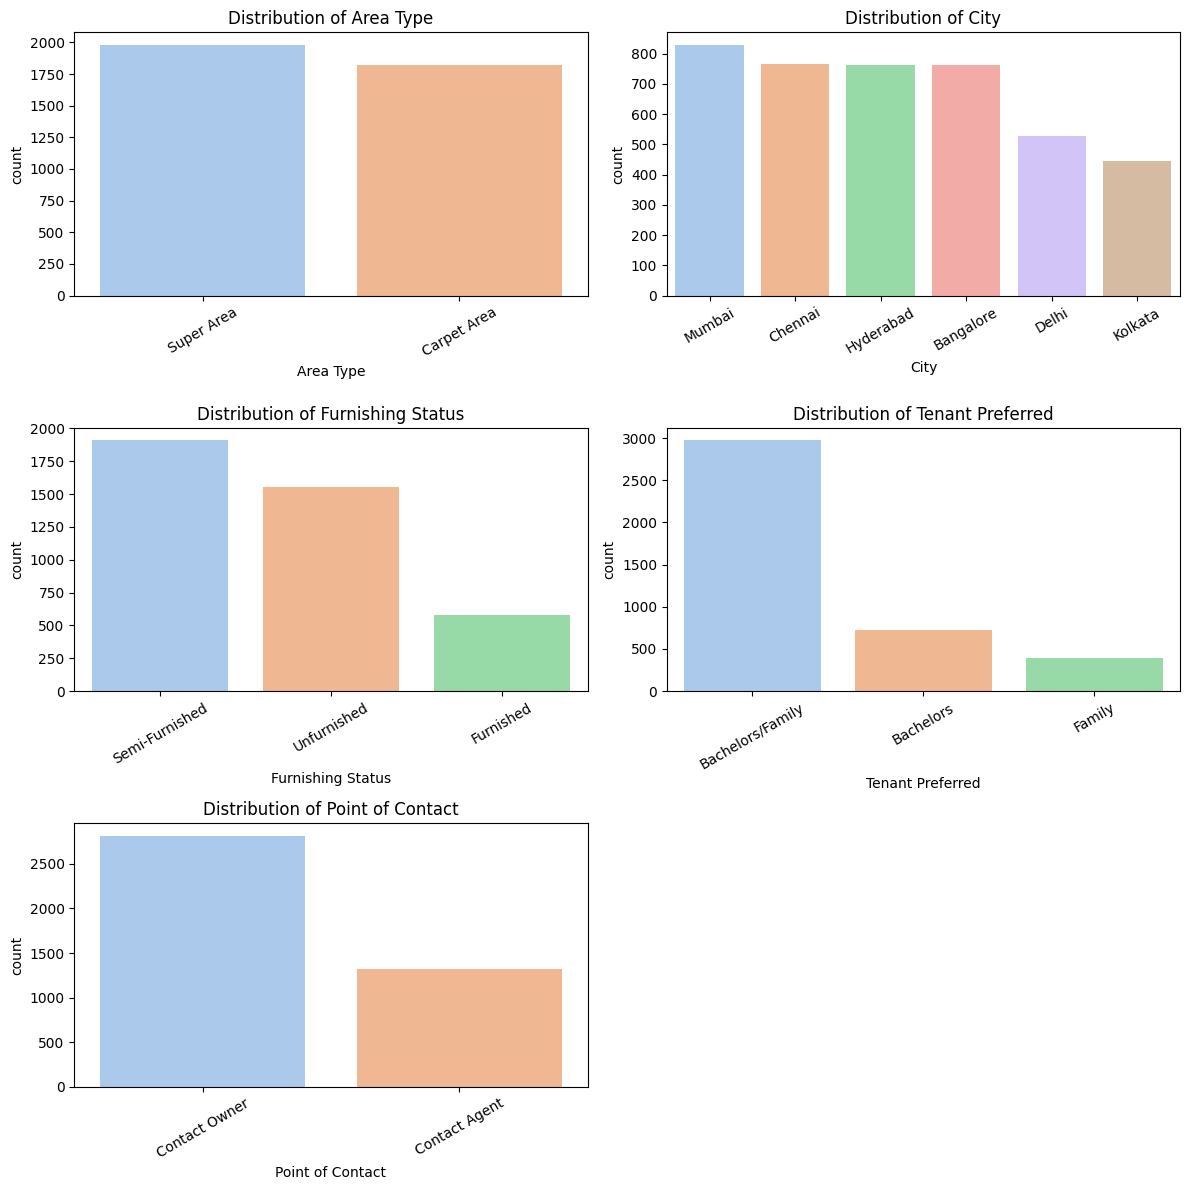

In [58]:
categorical_cols= ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']

n_cols= 2
n_rows= (len(categorical_cols) + n_cols - 1) // n_cols

plt.figure(figsize= (n_cols*6, n_rows*4))

for i, col in enumerate (categorical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    count = data[col].value_counts()
    sns.countplot(data=data, x=col, palette='pastel', order=count.index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation= 30)

plt.tight_layout()
plt.show()

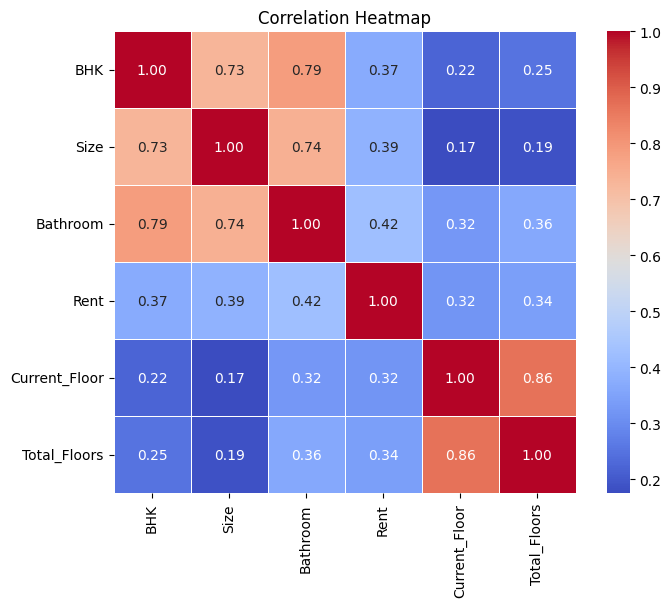

In [59]:
numeric_cols= ['BHK', 'Size', 'Bathroom', 'Rent', 'Current_Floor', 'Total_Floors']

plt.figure(figsize= (8,6))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt= ".2f",square= True, linewidth= 0.5)
plt.title("Correlation Heatmap")
plt.show()

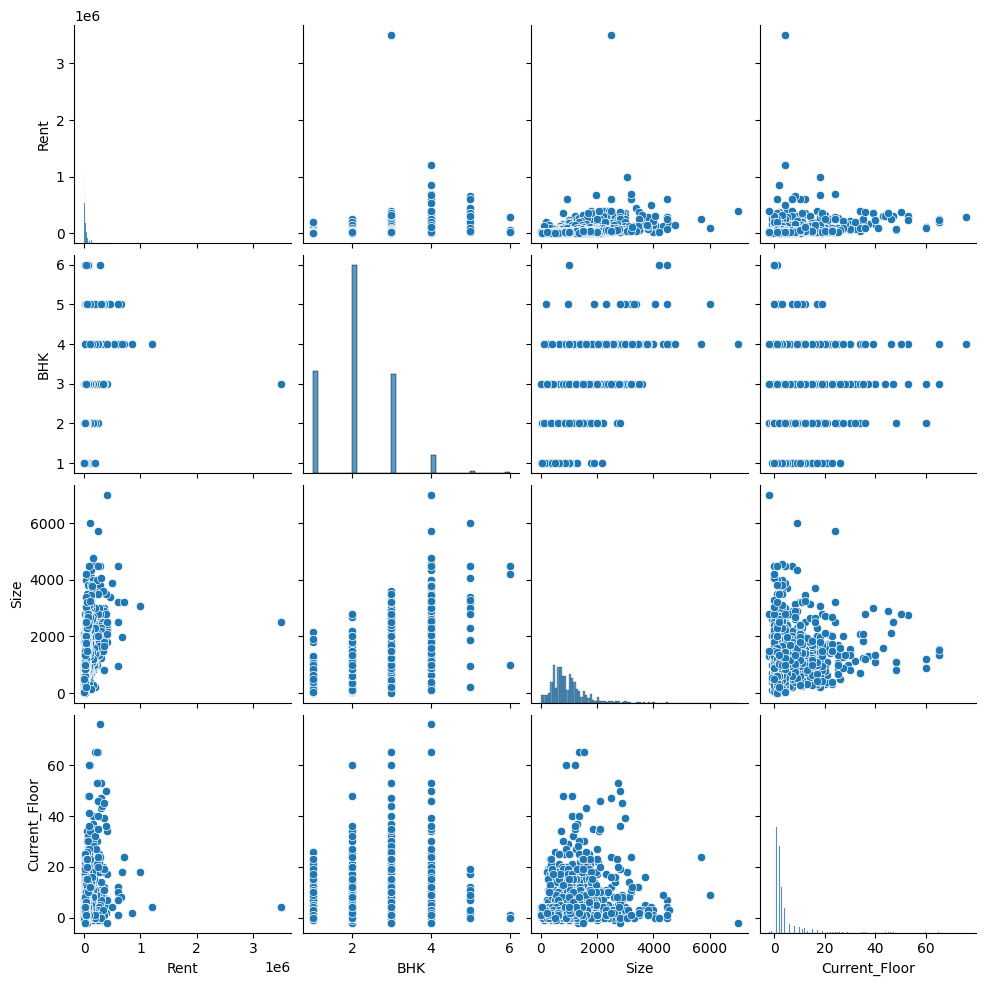

In [60]:
numeric_cols= ['Rent', 'BHK', 'Size', 'Current_Floor']
sns.pairplot(data[numeric_cols])
plt.show()

## **Summary:**
##### The correlation analysis shows that BHK, Size, and Bathroom are strongly related
##### Rent moderately correlates with Size and Current Floor.
##### This insight can guide us for imputing missing values.

### **Handling Missing Values**

In [61]:
data.head()

,BHK,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors
0,2.0,1100.0,Super Area,Other,Kolkata,Unfurnished,Bachelors/Family,2.0,Contact Owner,10000,NaN,NaN,NaN
1,2.0,800.0,Super Area,Other,Kolkata,Semi-Furnished,Bachelors/Family,NaN,NaN,20000,5.0,1.0,3.0
2,2.0,1000.0,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,NaN,1.0,Contact Owner,17000,5.0,1.0,3.0
3,2.0,800.0,Super Area,NaN,NaN,Unfurnished,Bachelors/Family,1.0,NaN,10000,7.0,1.0,2.0
4,2.0,850.0,Carpet Area,Other,Kolkata,Unfurnished,Bachelors,1.0,Contact Owner,7500,5.0,1.0,2.0


In [62]:
data.isna().sum()

BHK                  783
Size                 920
Area Type            942
Area Locality        600
City                 655
Furnishing Status    704
Tenant Preferred     652
Bathroom             541
Point of Contact     609
Rent                   0
Posted_Month         662
Current_Floor        786
Total_Floors         786
dtype: int64

In [63]:
data['BHK']= data['BHK'].fillna(data['BHK'].median())

In [64]:
data['BHK'].isna().sum()

0

In [65]:
data['BHK'].value_counts()

BHK
2.0    2704
1.0     947
3.0     911
4.0     162
5.0      17
6.0       5
Name: count, dtype: int64

In [66]:
data['Bathroom'].value_counts()

Bathroom
2.0     2041
1.0     1316
3.0      645
4.0      140
5.0       51
6.0        8
7.0        3
10.0       1
Name: count, dtype: int64

In [67]:
data['Bathroom']= data.groupby('BHK')['Bathroom'].transform(lambda x: x.fillna(x.median()))

In [68]:
data['Bathroom'].value_counts()

Bathroom
2.0     2333
1.0     1407
3.0      779
4.0      162
5.0       53
6.0        8
7.0        3
10.0       1
Name: count, dtype: int64

In [69]:
data.isna().sum()

BHK                    0
Size                 920
Area Type            942
Area Locality        600
City                 655
Furnishing Status    704
Tenant Preferred     652
Bathroom               0
Point of Contact     609
Rent                   0
Posted_Month         662
Current_Floor        786
Total_Floors         786
dtype: int64

In [70]:
data['Size']= data.groupby('BHK')['Size'].transform(lambda x: x.fillna(x.median()))

In [71]:
data['Size'].isna().sum()

0

In [72]:
data.head()

,BHK,Size,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors
0,2.0,1100.0,Super Area,Other,Kolkata,Unfurnished,Bachelors/Family,2.0,Contact Owner,10000,NaN,NaN,NaN
1,2.0,800.0,Super Area,Other,Kolkata,Semi-Furnished,Bachelors/Family,2.0,NaN,20000,5.0,1.0,3.0
2,2.0,1000.0,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,NaN,1.0,Contact Owner,17000,5.0,1.0,3.0
3,2.0,800.0,Super Area,NaN,NaN,Unfurnished,Bachelors/Family,1.0,NaN,10000,7.0,1.0,2.0
4,2.0,850.0,Carpet Area,Other,Kolkata,Unfurnished,Bachelors,1.0,Contact Owner,7500,5.0,1.0,2.0


In [73]:
data.isna().sum()

BHK                    0
Size                   0
Area Type            942
Area Locality        600
City                 655
Furnishing Status    704
Tenant Preferred     652
Bathroom               0
Point of Contact     609
Rent                   0
Posted_Month         662
Current_Floor        786
Total_Floors         786
dtype: int64

In [74]:
data['City'].value_counts()

City
Mumbai       829
Chennai      767
Hyderabad    763
Bangalore    761
Delhi        527
Kolkata      444
Name: count, dtype: int64

In [75]:
data['Area Locality'].value_counts()

Area Locality
Other                                     2642
Bandra West                                 34
Gachibowli                                  27
Electronic City                             23
Miyapur, NH 9                               19
                                          ... 
Chandivali                                   5
Shapoorji Pallonji Vicinia, Chandivali       5
Bhandup West                                 5
Financial District, Nanakram Guda            5
Nungambakkam                                 5
Name: count, Length: 182, dtype: int64

In [76]:
area_to_city= data.groupby('Area Locality')['City'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).to_dict()
data['City']= data.apply(lambda row: area_to_city[row['Area Locality']] if pd.isna(row['City']) and pd.notna(row['Area Locality']) else row['City'], axis=1)

In [77]:
data['City'].isna().sum()

83

In [78]:
data['City']= data['City'].fillna(data['City'].mode()[0])

In [79]:
data['City'].isna().sum()

0

In [80]:
data['Area Locality']= data.groupby('City')['Area Locality'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
)

In [81]:
data['Area Locality'].isna().sum()

0

In [82]:
data.isna().sum()

BHK                    0
Size                   0
Area Type            942
Area Locality          0
City                   0
Furnishing Status    704
Tenant Preferred     652
Bathroom               0
Point of Contact     609
Rent                   0
Posted_Month         662
Current_Floor        786
Total_Floors         786
dtype: int64

In [83]:
data['Area Type'].value_counts()

Area Type
Super Area     1980
Carpet Area    1824
Name: count, dtype: int64

### Filling Missing Values in "Area Type"
##### Use KNN Imputer to fill missing Area Type based on similar rows using BHK and Size.
##### Categorical values are temporarily encoded to numbers and converted back after imputation.

In [84]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer

cols_numeric= ['BHK', 'Size']
col_target= ['Area Type']

data_knn= data[cols_numeric+col_target].copy()

encoder= OrdinalEncoder()
mask_notna = data_knn['Area Type'].notna()
data_knn.loc[mask_notna, 'Area Type'] = encoder.fit_transform(data_knn.loc[mask_notna, ['Area Type']])

scaler= StandardScaler()
data_knn[cols_numeric]= scaler.fit_transform(data_knn[cols_numeric])

imputer= KNNImputer(n_neighbors=5)
data_knn_imputed= imputer.fit_transform(data_knn)

data_knn_imputed= pd.DataFrame(data_knn_imputed, columns=cols_numeric+col_target) 

data_knn_imputed[col_target]= encoder.inverse_transform(data_knn_imputed[col_target])

data['Area Type']= data_knn_imputed['Area Type']

In [85]:
data['Area Type'].isna().sum()

0

In [86]:
data['Area Type'].value_counts()

Area Type
Carpet Area    2713
Super Area     2033
Name: count, dtype: int64

In [87]:
data.isna().sum()

BHK                    0
Size                   0
Area Type              0
Area Locality          0
City                   0
Furnishing Status    704
Tenant Preferred     652
Bathroom               0
Point of Contact     609
Rent                   0
Posted_Month         662
Current_Floor        786
Total_Floors         786
dtype: int64

In [88]:
data['Point of Contact'].value_counts()

Point of Contact
Contact Owner    2815
Contact Agent    1322
Name: count, dtype: int64

In [89]:
data['Point of Contact']= data.groupby('City')['Point of Contact'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Contact Owner')
)

In [90]:
data['Point of Contact'].isna().sum()

0

In [91]:
data['Point of Contact'].value_counts()

Point of Contact
Contact Owner    3252
Contact Agent    1494
Name: count, dtype: int64

In [92]:
data.isna().sum()

BHK                    0
Size                   0
Area Type              0
Area Locality          0
City                   0
Furnishing Status    704
Tenant Preferred     652
Bathroom               0
Point of Contact       0
Rent                   0
Posted_Month         662
Current_Floor        786
Total_Floors         786
dtype: int64

In [93]:
data['Furnishing Status'].value_counts()

Furnishing Status
Semi-Furnished    1908
Unfurnished       1555
Furnished          579
Name: count, dtype: int64

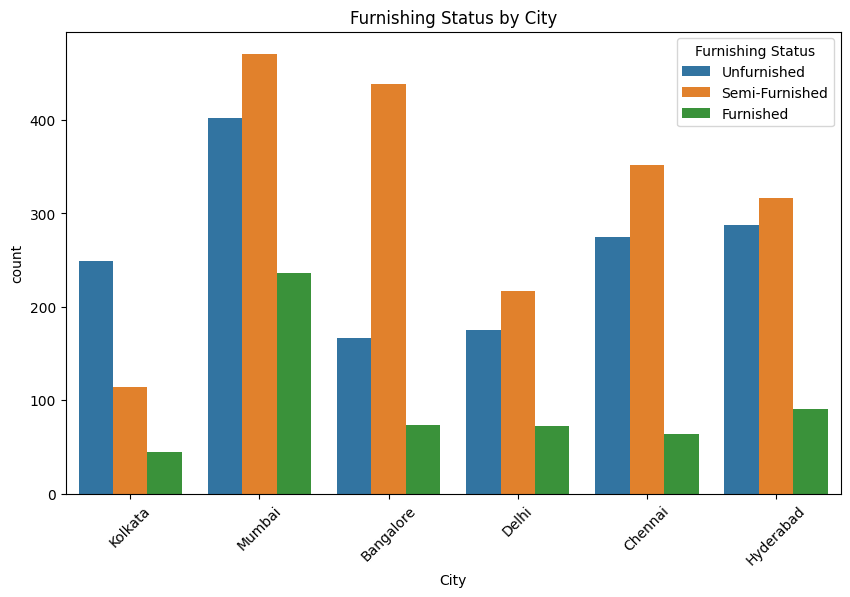

In [94]:
plt.figure(figsize= (10,6))
sns.countplot(data= data, x="City", hue="Furnishing Status")
plt.title("Furnishing Status by City")
plt.xticks(rotation= 45)
plt.show()

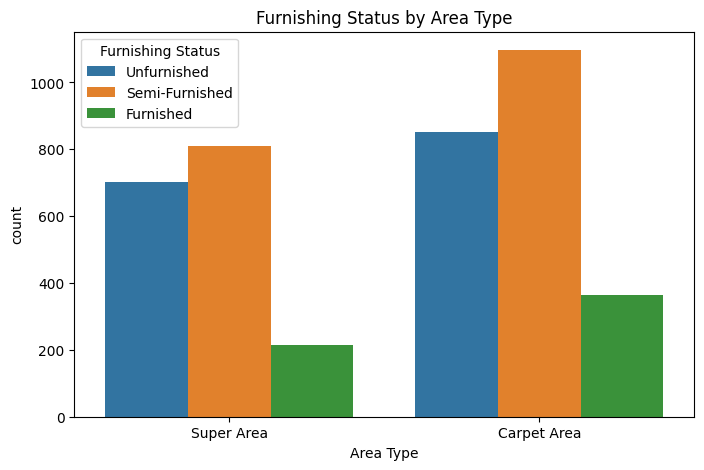

In [95]:
plt.figure(figsize= (8,5))
sns.countplot(data= data, x= "Area Type", hue= "Furnishing Status")
plt.title("Furnishing Status by Area Type")
plt.show()

In [96]:
# we will fill the missing values in 'Furnishing Status' according to the city

data['Furnishing Status']= data.groupby('City')['Furnishing Status'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Semi-Furnished')
)

In [97]:
data['Furnishing Status'].isna().sum()

0

In [98]:
data['Furnishing Status'].value_counts()

Furnishing Status
Semi-Furnished    2555
Unfurnished       1612
Furnished          579
Name: count, dtype: int64

In [99]:
data.isna().sum()

BHK                    0
Size                   0
Area Type              0
Area Locality          0
City                   0
Furnishing Status      0
Tenant Preferred     652
Bathroom               0
Point of Contact       0
Rent                   0
Posted_Month         662
Current_Floor        786
Total_Floors         786
dtype: int64

In [100]:
data['Tenant Preferred'].value_counts()

Tenant Preferred
Bachelors/Family    2973
Bachelors            722
Family               399
Name: count, dtype: int64

In [101]:
cols_numeric= ['BHK', 'Bathroom']
col_target= ['Tenant Preferred']

data_knn= data[cols_numeric+col_target].copy()

encoder= OrdinalEncoder()
mask_notna = data_knn['Tenant Preferred'].notna()
data_knn.loc[mask_notna, 'Tenant Preferred'] = encoder.fit_transform(data_knn.loc[mask_notna, ['Tenant Preferred']])

scaler= StandardScaler()
data_knn[cols_numeric]= scaler.fit_transform(data_knn[cols_numeric])

imputer= KNNImputer(n_neighbors=5)
data_knn_imputed= imputer.fit_transform(data_knn)

data_knn_imputed= pd.DataFrame(data_knn_imputed, columns=cols_numeric+col_target) 

data_knn_imputed[col_target]= encoder.inverse_transform(data_knn_imputed[col_target])

data['Tenant Preferred']= data_knn_imputed['Tenant Preferred']

In [102]:
data['Tenant Preferred'].isna().sum()

0

In [103]:
data['Tenant Preferred'].value_counts()

Tenant Preferred
Bachelors/Family    3099
Bachelors           1248
Family               399
Name: count, dtype: int64

In [104]:
data.isna().sum()

BHK                    0
Size                   0
Area Type              0
Area Locality          0
City                   0
Furnishing Status      0
Tenant Preferred       0
Bathroom               0
Point of Contact       0
Rent                   0
Posted_Month         662
Current_Floor        786
Total_Floors         786
dtype: int64

In [105]:
data['Posted_Month'].value_counts()

Posted_Month
6.0    1589
5.0    1460
7.0     840
4.0     195
Name: count, dtype: int64

In [106]:
months= [6, 5, 7, 4]
counts= [1589, 1460, 840, 195]

probabilities= np.array(counts)/ sum(counts)

nan_idx= data['Posted_Month'].isna()

data.loc[nan_idx, 'Posted_Month']= np.random.choice(months, size= nan_idx.sum(), p=probabilities)

In [107]:
data['Posted_Month'].isna().sum()

0

In [108]:
data['Posted_Month'].value_counts()

Posted_Month
6.0    1832
5.0    1729
7.0     968
4.0     217
Name: count, dtype: int64

In [109]:
data.isna().sum()

BHK                    0
Size                   0
Area Type              0
Area Locality          0
City                   0
Furnishing Status      0
Tenant Preferred       0
Bathroom               0
Point of Contact       0
Rent                   0
Posted_Month           0
Current_Floor        786
Total_Floors         786
dtype: int64

In [110]:
data['Current_Floor'].value_counts()

Current_Floor
 1.0     981
 2.0     801
 0.0     766
 3.0     423
 4.0     224
 5.0     133
 6.0      75
 8.0      58
 7.0      58
 10.0     54
 9.0      53
 12.0     41
 11.0     37
 15.0     33
 14.0     32
 18.0     23
 17.0     20
-1.0      17
 16.0     15
 19.0     14
 13.0     12
 20.0     10
 25.0      8
 23.0      7
 21.0      6
-2.0       6
 24.0      5
 30.0      5
 34.0      4
 35.0      3
 65.0      3
 27.0      3
 26.0      3
 28.0      2
 48.0      2
 40.0      2
 32.0      2
 53.0      2
 22.0      2
 60.0      2
 36.0      2
 76.0      1
 29.0      1
 50.0      1
 43.0      1
 46.0      1
 41.0      1
 44.0      1
 37.0      1
 47.0      1
 39.0      1
 45.0      1
Name: count, dtype: int64

In [111]:
data['Current_Floor']= data['Current_Floor'].fillna(data['Current_Floor'].median())

In [112]:
data['Current_Floor'].isna().sum()

0

In [113]:
data.isna().sum()

BHK                    0
Size                   0
Area Type              0
Area Locality          0
City                   0
Furnishing Status      0
Tenant Preferred       0
Bathroom               0
Point of Contact       0
Rent                   0
Posted_Month           0
Current_Floor          0
Total_Floors         786
dtype: int64

In [114]:
data['Total_Floors']= data['Total_Floors'].fillna(data['Total_Floors'].median())

In [115]:
data['Total_Floors'].isna().sum()

0

In [116]:
data.isna().sum()

BHK                  0
Size                 0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
Rent                 0
Posted_Month         0
Current_Floor        0
Total_Floors         0
dtype: int64

### **Handling Outliers:**

In [117]:
data.dtypes

BHK                  float64
Size                 float64
Area Type             object
Area Locality         object
City                  object
Furnishing Status     object
Tenant Preferred      object
Bathroom             float64
Point of Contact      object
Rent                   int64
Posted_Month         float64
Current_Floor        float64
Total_Floors         float64
dtype: object

In [118]:
data.describe()

,BHK,Size,Bathroom,Rent,Posted_Month,Current_Floor,Total_Floors
count,4746.000000,4746.000000,4746.000000,4.746000e+03,4746.000000,4746.000000,4746.000000
mean,2.075643,958.852086,1.981037,3.499345e+04,5.748209,3.210704,6.467762
std,0.755987,594.111405,0.868157,7.810641e+04,0.829400,5.351369,8.787163
min,1.000000,10.000000,1.000000,1.200000e+03,4.000000,-2.000000,1.000000
25%,2.000000,600.000000,1.000000,1.000000e+04,5.000000,1.000000,3.000000
50%,2.000000,826.000000,2.000000,1.600000e+04,6.000000,2.000000,4.000000
75%,2.000000,1200.000000,2.000000,3.300000e+04,6.000000,3.000000,5.000000
max,6.000000,7000.000000,10.000000,3.500000e+06,7.000000,76.000000,89.000000


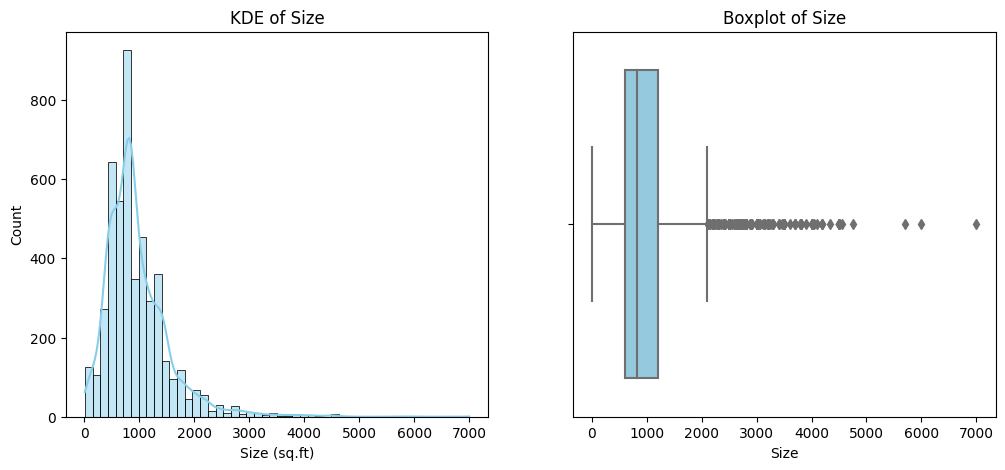

In [119]:
plt.figure(figsize= (12,5))

plt.subplot(1,2,1)
sns.histplot(data['Size'], bins=50, kde=True, color='skyblue')
plt.title("KDE of Size")
plt.xlabel("Size (sq.ft)")
plt.ylabel("Count")

plt.subplot(1,2,2)
sns.boxplot(x=data['Size'], color="skyblue")
plt.title("Boxplot of Size")

plt.show()

In [120]:
Q1= data['Size'].quantile(0.25)
Q3= data['Size'].quantile(0.75)
IQR= Q3-Q1

lower_bound= Q1 - 1.5*IQR
upper_bound= Q3 + 1.5*IQR

outliers= data[(data['Size']<lower_bound) | (data['Size']>upper_bound)]

print(f"Size has {len(outliers)} outlier")

Size has 206 outlier


In [121]:
def cap_outliers(df, col):
    Q1= df[col].quantile(0.25)
    Q3= df[col].quantile(0.75)
    IQR= Q3-Q1
    lower_bound= Q1-1.5*IQR
    upper_bound= Q3+1.5*IQR
    df[col]= df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

In [122]:
data= cap_outliers(data,'Size')

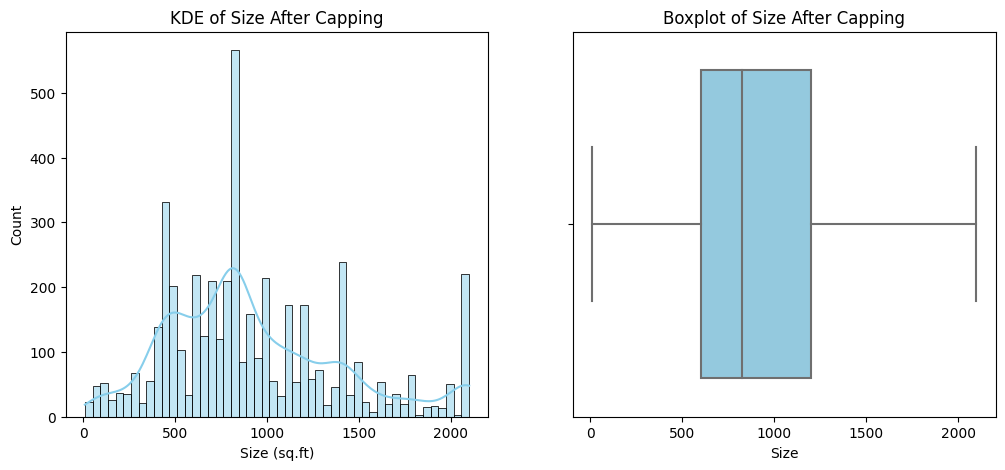

In [123]:
plt.figure(figsize= (12,5))

plt.subplot(1,2,1)
sns.histplot(data['Size'], bins=50, kde=True, color='skyblue')
plt.title("KDE of Size After Capping")
plt.xlabel("Size (sq.ft)")
plt.ylabel("Count")

plt.subplot(1,2,2)
sns.boxplot(x=data['Size'], color="skyblue")
plt.title("Boxplot of Size After Capping")

plt.show()

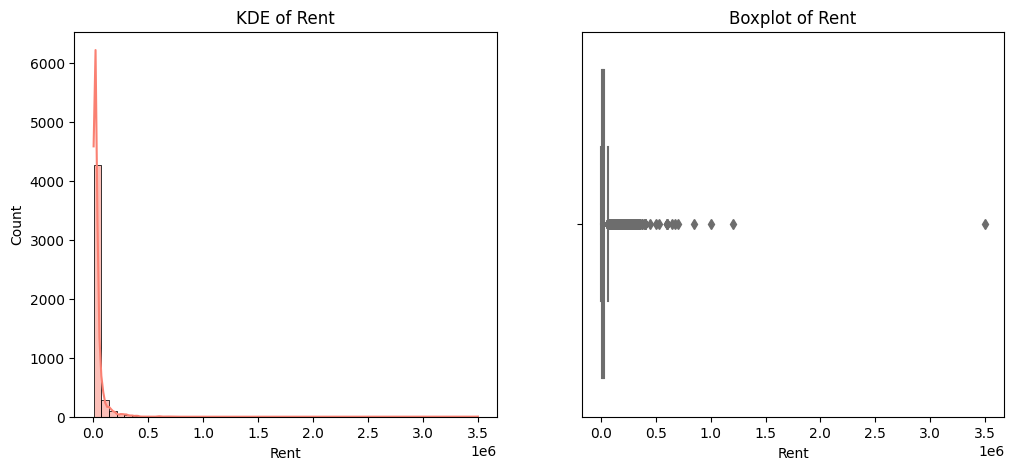

In [124]:
plt.figure(figsize= (12,5))

plt.subplot(1,2,1)
sns.histplot(data['Rent'], bins=50, kde=True, color='Salmon')
plt.title("KDE of Rent")
plt.xlabel("Rent")
plt.ylabel("Count")

plt.subplot(1,2,2)
sns.boxplot(x=data['Rent'], color="Salmon")
plt.title("Boxplot of Rent")

plt.show()

In [125]:
Q1= data['Rent'].quantile(0.25)
Q3= data['Rent'].quantile(0.75)
IQR= Q3-Q1

lower_bound= Q1 - 1.5*IQR
upper_bound= Q3 + 1.5*IQR

outliers= data[(data['Rent']<lower_bound) | (data['Rent']>upper_bound)]

print(f"Rent has {len(outliers)} outlier")

Rent has 520 outlier


In [126]:
data= cap_outliers(data,'Rent')

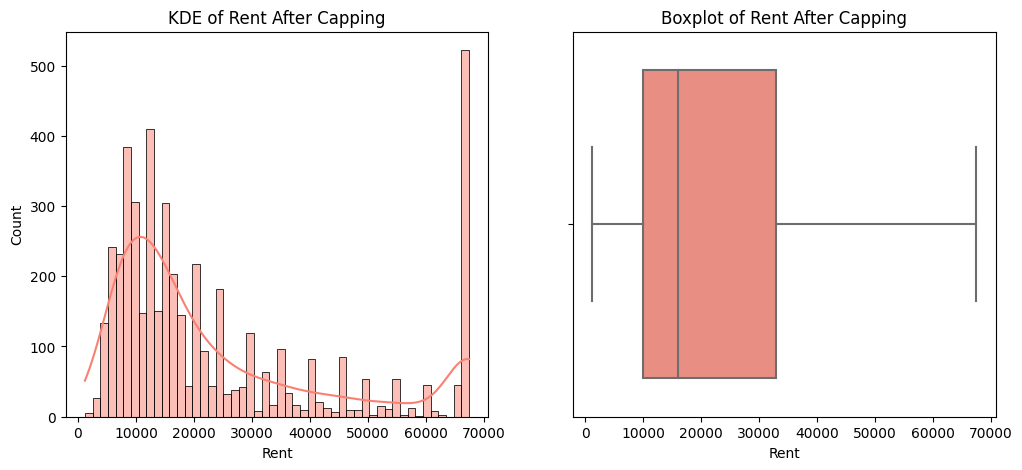

In [127]:
plt.figure(figsize= (12,5))

plt.subplot(1,2,1)
sns.histplot(data['Rent'], bins=50, kde=True, color='Salmon')
plt.title("KDE of Rent After Capping")
plt.xlabel("Rent")
plt.ylabel("Count")

plt.subplot(1,2,2)
sns.boxplot(x=data['Rent'], color="Salmon")
plt.title("Boxplot of Rent After Capping")

plt.show()

## **Encoding**

In [128]:
data.dtypes

BHK                  float64
Size                 float64
Area Type             object
Area Locality         object
City                  object
Furnishing Status     object
Tenant Preferred      object
Bathroom             float64
Point of Contact      object
Rent                   int64
Posted_Month         float64
Current_Floor        float64
Total_Floors         float64
dtype: object

In [129]:
data['Area Type'].value_counts()

Area Type
Carpet Area    2713
Super Area     2033
Name: count, dtype: int64

In [130]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
data['Area Type']= le.fit_transform(data['Area Type'])

In [131]:
data['Area Type'].value_counts()

Area Type
0    2713
1    2033
Name: count, dtype: int64

In [132]:
data.dtypes

BHK                  float64
Size                 float64
Area Type              int64
Area Locality         object
City                  object
Furnishing Status     object
Tenant Preferred      object
Bathroom             float64
Point of Contact      object
Rent                   int64
Posted_Month         float64
Current_Floor        float64
Total_Floors         float64
dtype: object

In [133]:
data['Point of Contact'].value_counts()

Point of Contact
Contact Owner    3252
Contact Agent    1494
Name: count, dtype: int64

In [134]:
le= LabelEncoder()
data['Point of Contact']= le.fit_transform(data['Point of Contact'])

In [135]:
data['Point of Contact'].value_counts()

Point of Contact
1    3252
0    1494
Name: count, dtype: int64

In [136]:
data.dtypes

BHK                  float64
Size                 float64
Area Type              int64
Area Locality         object
City                  object
Furnishing Status     object
Tenant Preferred      object
Bathroom             float64
Point of Contact       int64
Rent                   int64
Posted_Month         float64
Current_Floor        float64
Total_Floors         float64
dtype: object

In [137]:
data['Furnishing Status'].value_counts()

Furnishing Status
Semi-Furnished    2555
Unfurnished       1612
Furnished          579
Name: count, dtype: int64

In [138]:
data= pd.get_dummies(data, columns=['Furnishing Status'], drop_first=True)

In [139]:
data.head()

,BHK,Size,Area Type,Area Locality,City,Tenant Preferred,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished
0,2.0,1100.0,1,Other,Kolkata,Bachelors/Family,2.0,1,10000,6.0,2.0,4.0,False,True
1,2.0,800.0,1,Other,Kolkata,Bachelors/Family,2.0,1,20000,5.0,1.0,3.0,True,False
2,2.0,1000.0,1,Salt Lake City Sector 2,Kolkata,Bachelors,1.0,1,17000,5.0,1.0,3.0,True,False
3,2.0,800.0,1,Other,Mumbai,Bachelors/Family,1.0,0,10000,7.0,1.0,2.0,False,True
4,2.0,850.0,0,Other,Kolkata,Bachelors,1.0,1,7500,5.0,1.0,2.0,False,True


In [140]:
data.dtypes

BHK                                 float64
Size                                float64
Area Type                             int64
Area Locality                        object
City                                 object
Tenant Preferred                     object
Bathroom                            float64
Point of Contact                      int64
Rent                                  int64
Posted_Month                        float64
Current_Floor                       float64
Total_Floors                        float64
Furnishing Status_Semi-Furnished       bool
Furnishing Status_Unfurnished          bool
dtype: object

In [141]:
data= pd.get_dummies(data, columns=['Tenant Preferred'], drop_first=True)

In [142]:
data.head()

,BHK,Size,Area Type,Area Locality,City,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family
0,2.0,1100.0,1,Other,Kolkata,2.0,1,10000,6.0,2.0,4.0,False,True,True,False
1,2.0,800.0,1,Other,Kolkata,2.0,1,20000,5.0,1.0,3.0,True,False,True,False
2,2.0,1000.0,1,Salt Lake City Sector 2,Kolkata,1.0,1,17000,5.0,1.0,3.0,True,False,False,False
3,2.0,800.0,1,Other,Mumbai,1.0,0,10000,7.0,1.0,2.0,False,True,True,False
4,2.0,850.0,0,Other,Kolkata,1.0,1,7500,5.0,1.0,2.0,False,True,False,False


In [143]:
data.shape

(4746, 15)

In [144]:
data.dtypes

BHK                                  float64
Size                                 float64
Area Type                              int64
Area Locality                         object
City                                  object
Bathroom                             float64
Point of Contact                       int64
Rent                                   int64
Posted_Month                         float64
Current_Floor                        float64
Total_Floors                         float64
Furnishing Status_Semi-Furnished        bool
Furnishing Status_Unfurnished           bool
Tenant Preferred_Bachelors/Family       bool
Tenant Preferred_Family                 bool
dtype: object

In [145]:
data['City'].value_counts()

City
Mumbai       1306
Chennai       824
Hyderabad     806
Bangalore     794
Delhi         552
Kolkata       464
Name: count, dtype: int64

In [146]:
data= pd.get_dummies(data, columns=['City'], drop_first=True)

In [147]:
data.head()

,BHK,Size,Area Type,Area Locality,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,City_Chennai,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai
0,2.0,1100.0,1,Other,2.0,1,10000,6.0,2.0,4.0,False,True,True,False,False,False,False,True,False
1,2.0,800.0,1,Other,2.0,1,20000,5.0,1.0,3.0,True,False,True,False,False,False,False,True,False
2,2.0,1000.0,1,Salt Lake City Sector 2,1.0,1,17000,5.0,1.0,3.0,True,False,False,False,False,False,False,True,False
3,2.0,800.0,1,Other,1.0,0,10000,7.0,1.0,2.0,False,True,True,False,False,False,False,False,True
4,2.0,850.0,0,Other,1.0,1,7500,5.0,1.0,2.0,False,True,False,False,False,False,False,True,False


In [148]:
data.dtypes

BHK                                  float64
Size                                 float64
Area Type                              int64
Area Locality                         object
Bathroom                             float64
Point of Contact                       int64
Rent                                   int64
Posted_Month                         float64
Current_Floor                        float64
Total_Floors                         float64
Furnishing Status_Semi-Furnished        bool
Furnishing Status_Unfurnished           bool
Tenant Preferred_Bachelors/Family       bool
Tenant Preferred_Family                 bool
City_Chennai                            bool
City_Delhi                              bool
City_Hyderabad                          bool
City_Kolkata                            bool
City_Mumbai                             bool
dtype: object

In [149]:
cols_to_int= ['Furnishing Status_Semi-Furnished', 'Furnishing Status_Unfurnished', 'Tenant Preferred_Bachelors/Family', 'Tenant Preferred_Family', 'City_Chennai', 'City_Delhi', 'City_Hyderabad', 'City_Kolkata', 'City_Mumbai']

for col in cols_to_int:
    data[col]= data[col].astype('int')

In [150]:
data.dtypes

BHK                                  float64
Size                                 float64
Area Type                              int64
Area Locality                         object
Bathroom                             float64
Point of Contact                       int64
Rent                                   int64
Posted_Month                         float64
Current_Floor                        float64
Total_Floors                         float64
Furnishing Status_Semi-Furnished       int64
Furnishing Status_Unfurnished          int64
Tenant Preferred_Bachelors/Family      int64
Tenant Preferred_Family                int64
City_Chennai                           int64
City_Delhi                             int64
City_Hyderabad                         int64
City_Kolkata                           int64
City_Mumbai                            int64
dtype: object

In [151]:
data['Area Locality'].nunique()

182

In [152]:
area_freq= data['Area Locality'].value_counts().reset_index()
area_freq.columns= ['Area Locality', 'Frequency']

area_rent= data.groupby('Area Locality')['Rent'].mean().reset_index()

freq_rent= area_freq.merge(area_rent, on='Area Locality', how='left')

correlation= freq_rent['Frequency'].corr(freq_rent['Rent'])

print(f"Correlation between frequency and average Rent: {correlation}")

Correlation between frequency and average Rent: 0.018760883773152336


## **Warning!**
##### Freq Encoding will not work well here
##### I will try Label Encoding and use Tree_Based Models, it might enhance our model performance
##### Not 100% sure, but let's try and see how it goes

In [153]:
le= LabelEncoder()
data['Area Locality']= le.fit_transform(data['Area Locality'])

In [154]:
data.dtypes

BHK                                  float64
Size                                 float64
Area Type                              int64
Area Locality                          int64
Bathroom                             float64
Point of Contact                       int64
Rent                                   int64
Posted_Month                         float64
Current_Floor                        float64
Total_Floors                         float64
Furnishing Status_Semi-Furnished       int64
Furnishing Status_Unfurnished          int64
Tenant Preferred_Bachelors/Family      int64
Tenant Preferred_Family                int64
City_Chennai                           int64
City_Delhi                             int64
City_Hyderabad                         int64
City_Kolkata                           int64
City_Mumbai                            int64
dtype: object

In [155]:
data.head()

,BHK,Size,Area Type,Area Locality,Bathroom,Point of Contact,Rent,Posted_Month,Current_Floor,Total_Floors,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,City_Chennai,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai
0,2.0,1100.0,1,126,2.0,1,10000,6.0,2.0,4.0,0,1,1,0,0,0,0,1,0
1,2.0,800.0,1,126,2.0,1,20000,5.0,1.0,3.0,1,0,1,0,0,0,0,1,0
2,2.0,1000.0,1,149,1.0,1,17000,5.0,1.0,3.0,1,0,0,0,0,0,0,1,0
3,2.0,800.0,1,126,1.0,0,10000,7.0,1.0,2.0,0,1,1,0,0,0,0,0,1
4,2.0,850.0,0,126,1.0,1,7500,5.0,1.0,2.0,0,1,0,0,0,0,0,1,0


## **Modeling**

In [158]:
from tabulate import tabulate
results=[]

X = data.drop(columns=['Rent'])  
y = data['Rent'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models={
    "Random Forest": RandomForestRegressor(random_state= 42),
    "Gradient Boosting": GradientBoostingRegressor(random_state= 42),
    "XGBoost": XGBRegressor(random_state= 42),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42, verbose=-1),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    
    mae= mean_absolute_error(y_test, y_pred)
    r2= r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results.append({"Model": name, "R2": r2,  "MAE": mae,"RMSE": rmse})

In [159]:
results_df= pd.DataFrame(results).sort_values(by="R2", ascending= False)
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))

╒═══════════════════╤══════════╤═════════╤══════════╕
│ Model             │       R2 │     MAE │     RMSE │
╞═══════════════════╪══════════╪═════════╪══════════╡
│ CatBoost          │ 0.816148 │ 5723.41 │  8442.01 │
├───────────────────┼──────────┼─────────┼──────────┤
│ LightGBM          │ 0.806129 │ 5913.49 │  8668.98 │
├───────────────────┼──────────┼─────────┼──────────┤
│ Random Forest     │ 0.795454 │ 5965.84 │  8904.45 │
├───────────────────┼──────────┼─────────┼──────────┤
│ Gradient Boosting │ 0.795381 │ 6127.94 │  8906.05 │
├───────────────────┼──────────┼─────────┼──────────┤
│ XGBoost           │ 0.793661 │ 5982.17 │  8943.4  │
├───────────────────┼──────────┼─────────┼──────────┤
│ Extra Trees       │ 0.775577 │ 6181.05 │  9327.07 │
├───────────────────┼──────────┼─────────┼──────────┤
│ Decision Tree     │ 0.594415 │ 7940.09 │ 12538.7  │
╘═══════════════════╧══════════╧═════════╧══════════╛


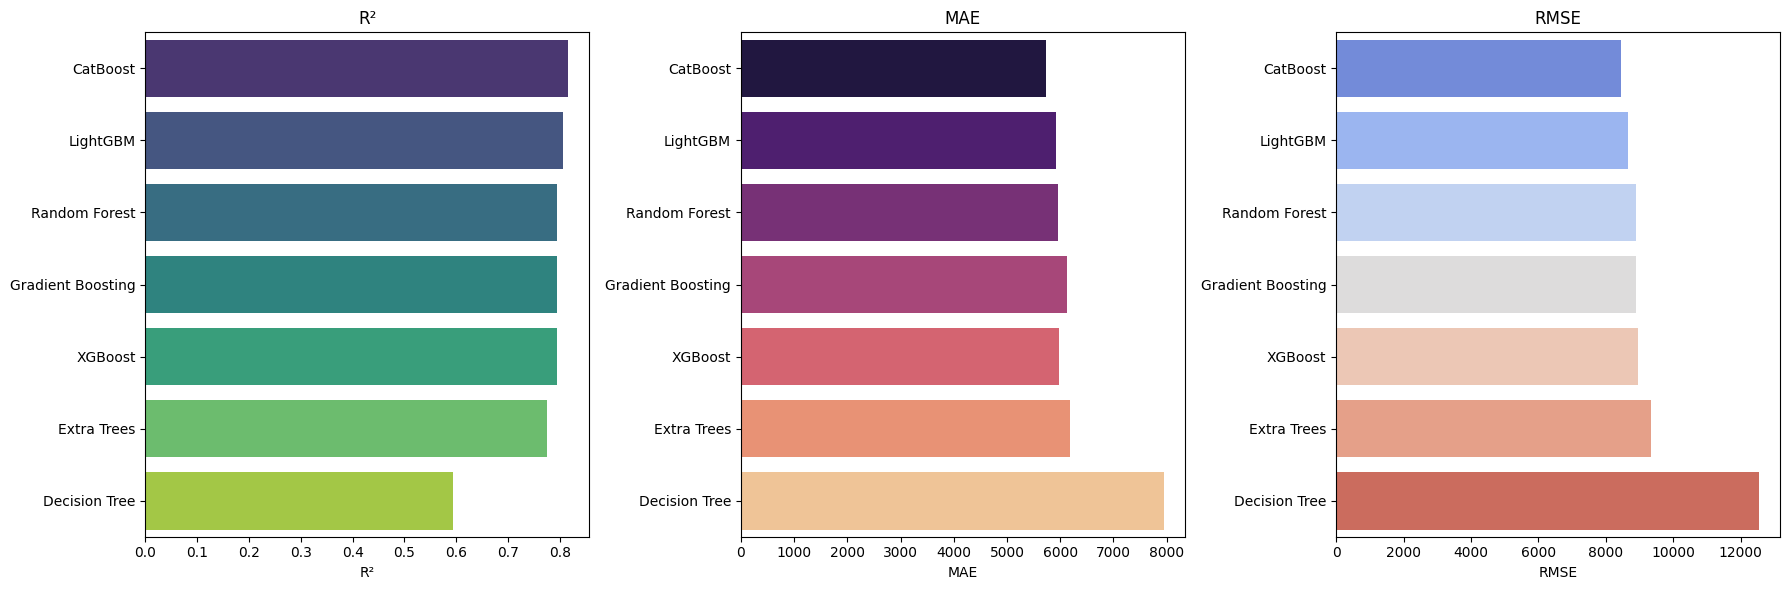

In [160]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# R²
sns.barplot(data=results_df, x='R2', y='Model', palette='viridis', ax=axes[0])
axes[0].set_title('R²')
axes[0].set_xlabel('R²')
axes[0].set_ylabel('')

# MAE
sns.barplot(data=results_df, x='MAE', y='Model', palette='magma', ax=axes[1])
axes[1].set_title('MAE')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('')

# RMSE
sns.barplot(data=results_df, x='RMSE', y='Model', palette='coolwarm', ax=axes[2])
axes[2].set_title('RMSE')
axes[2].set_xlabel('RMSE')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

## **Summary:**
#### Based on the evaluation metrics, CatBoost is the best performing model among all.
#### Therefore, we will proceed with hyperparameter tuning to further improve its performance

## **CatBoost Tuning**

In [161]:
cat_model= CatBoostRegressor(silent=True, random_state=42)

param_dist= {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [500, 1000, 1500]
}

# Randomized Search
random_search= RandomizedSearchCV(
    estimator=cat_model,
    param_distributions= param_dist,
    n_iter=20,
    scoring='r2',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Beat Parameters:", random_search.best_params_)
print("Best R2 on CV:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Beat Parameters: {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 1500, 'depth': 6}
Best R2 on CV: 0.7738236098690612


In [162]:
final_catboost= CatBoostRegressor(
    **random_search.best_params_,
    silent= True,
    random_state= 42
)

final_catboost.fit(X_train, y_train)
y_pred= final_catboost.predict(X_test)

r2= r2_score(y_test, y_pred)
mae= mean_absolute_error(y_test, y_pred)
rmse= np.sqrt(mean_squared_error(y_test, y_pred))

print("Final CatBoost Performance on Test Set:")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae: ,.0f}")
print(f"RMSE: {rmse: ,.0f}")

Final CatBoost Performance on Test Set:
R2: 0.8072
MAE:  5,853
RMSE:  8,645
[CV] END depth=4, iterations=1000, l2_leaf_reg=3, learning_rate=0.05; total time=   3.2s
[CV] END depth=4, iterations=1500, l2_leaf_reg=9, learning_rate=0.01; total time=   4.1s
[CV] END depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.01; total time=  25.9s
[CV] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time=   2.6s
[CV] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time=   2.3s
[CV] END depth=4, iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time=   2.6s
[CV] END depth=4, iterations=1000, l2_leaf_reg=7, learning_rate=0.01; total time=   2.4s
[CV] END depth=4, iterations=1000, l2_leaf_reg=7, learning_rate=0.01; total time=   2.7s
[CV] END depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.1; total time=  10.6s
[CV] END depth=8, iterations=1000, l2_leaf_reg=9, learning_rate=0.05; total time=   8.8s
[CV] END depth=10, iterations=1000

## **Conclusion**
#### Hyperparameter tuning of CatBoost did not notably improve R².
#### The results confirm the model is stable and already well-optimized, and tuning mainly ensuring consistent performance on unseen data.